# Clustering participants based on their cultural aspects

In [1]:
%%capture

# Boilerplate required to import other notebooks
import ipynb.fs

# From the full "data_preparation" notebook import function(s)
from .full.data_preparation import *

In [2]:
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

## Defining the set of items which represent the cultural aspects of the survey

### In Spanish

In [4]:
def get_cultural_items_esp():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                        '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                        '¿Conoces autores/as que trabajen produciendo imágenes?',
                        '¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                        'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?',
                        'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    mascVsFem = ['¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?',
                 '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?',
                 '¿Conoces autores/as que trabajen produciendo imágenes?']

    indivVsCollect = ['¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?',
                      'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?']

    avoidUndertIndex = ['Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?',
                        'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?',
                        'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?',
                        'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

### In English

In [5]:
def get_cultural_items_en():
    # Creating lists that includes the items from the cultural-related constructs

    allCulturalItems = ['Do you think that images produced by men are different from those made by women?',
                        'Do you think that in the creation of images work more women, or men?',
                        'Do you know authors who work producing images?',
                        'Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                        'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?',
                        'By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    mascVsFem = ['Do you think that images produced by men are different from those made by women?',
                 'Do you think that in the creation of images work more women, or men?',
                 'Do you know authors who work producing images?']

    indivVsCollect = ['Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?',
                      'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?']

    avoidUndertIndex = ['By reusing an image, can you redefine the message that the sender has thought about?',
                        'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?',
                        'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?',
                        'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?']

    return allCulturalItems, mascVsFem, indivVsCollect, avoidUndertIndex

## Exploring possible clusters

These functions explore the main clusters available in a dataframe. Functions to manage the data (and column names) available in Spanish and English


Also, we include two examples to show how to use the functions

In [6]:
def test_find_clusters_en(dataframe, n_clusters=12):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=n_clusters,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

In [7]:
def test_find_clusters_esp(dataframe, n_clusters=12):
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')

    # Ploting our dendrogram.
    colors = ['g', 'b', 'r', 'p', 'y', 'b', 'w']
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sources')
    plt.ylabel('Distance')
    dendrogram(cluster_tree, leaf_rotation=80.,
               leaf_font_size=14.,  color_threshold=4.5)
    plt.show()

    fancy_dendrogram(
        cluster_tree,
        truncate_mode='lastp',
        p=n_clusters,
        leaf_rotation=80.,
        leaf_font_size=14.,
        show_contracted=True,
        annotate_above=5,  # useful in small plots so annotations don't overlap
        color_threshold=4.5,
    )

    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



,Age,Are you able to express verbally the emotions produced by an image you have seen?,Classify your degree of vision,"Do you have access to devices (computer, mobile, tablet, etc.) connected to the Internet usually?","Do you have any visual deficiencies that affect the visual reception of shapes, colors, distances, etc.?",Do you repeat the images until you get the expected result?,Do you wear glasses or contact lenses?,"Do you, generally, understand the intentions of the author of an image when you see it and share it?","During that use, how many images do you consume (see and share)?",Educational level,...,Which of the paired images do you find most attractive? 1/2 2/2.1,Which of the paired images do you find most attractive? 1/2 2/2.2,Which of the paired images do you find most attractive? 1/2 2/2.3,Which of the paired images do you find most attractive? 1/2 2/2.4,With whom do you usually share images? [1. Friends],With whom do you usually share images? [2. Family],With whom do you usually share images? [3. Partners],With whom do you usually share images? [4. With all my acquaintances],With whom do you usually share images? [5. With nobody],"Within your social networks or mobile applications, do you see visual information that you are not looking for (social awareness campaigns, jokes, advertising, etc.)?"
0,0.348981,-0.484991,-1.218193,0.542426,-0.430664,0.597932,0.965396,-0.450957,-2.079521,0.690860,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
1,2.356095,-0.484991,-1.218193,0.542426,-0.430664,-1.672432,0.965396,-0.450957,0.163788,0.690860,...,0.920974,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,1.371487
2,-0.373580,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,1.285442,0.690860,...,-1.085807,-1.278960,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,0.430583
3,-0.132726,-0.484991,-0.035466,0.542426,-0.430664,0.597932,0.965396,0.603568,0.163788,0.690860,...,-1.085807,0.781885,0.714033,-0.938031,0.486926,0.535642,1.244256,-0.547723,-0.179726,-2.392128
4,-0.694718,-1.535804,-0.035466,0.542426,-0.430664,0.597932,0.965396,-0.450957,1.285442,-0.005447,...,-1.085807,0.781885,0.714033,1.066063,0.486926,0.535642,-0.803693,-0.547723,-0.179726,-0.510321


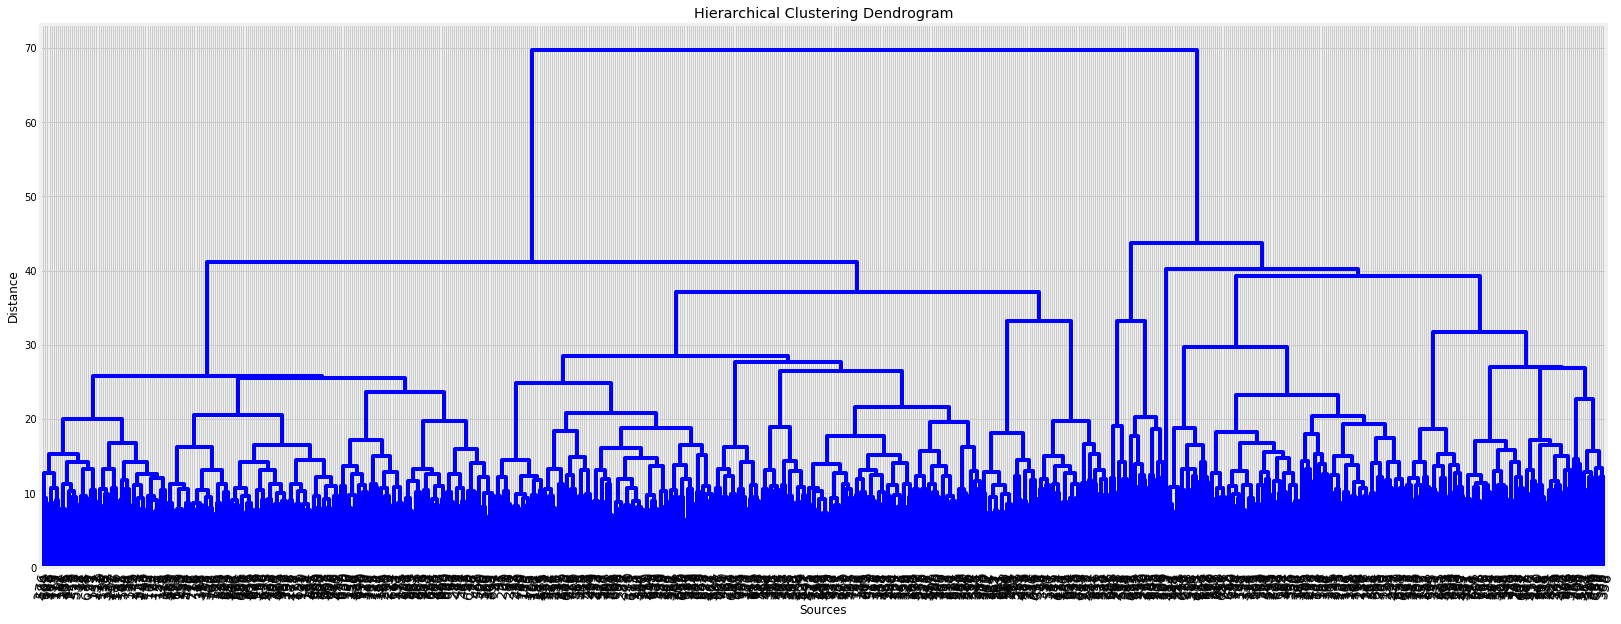

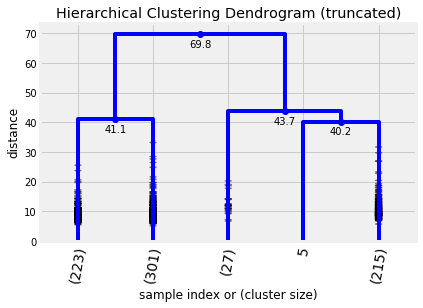

In [8]:
test_find_clusters_en(get_dataframe_analysis_en(True), 5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



,Clasifica tu grado de visión,"Cuando compartes imágenes, ¿habitualmente las envías a otras personas?","Cuando compartes imágenes, ¿habitualmente las produces tú?","Cuando compartes imágenes, ¿habitualmente las recibes de otras personas?","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [1. Cámara de fotos]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [2. Teléfono móvil]","Cuando generas una imagen, ¿qué tipo de dispositivo usas? (Respuesta múltiple) [3. Tableta]","Cuando observas estas imágenes, ¿entiendes lo que pasa, aunque los sujetos/objetos no se muestren de forma completa? 1 2 3 4","Cuando observas una imagen, ¿te preguntas cosas acerca de los personajes/objetos que aparecen en la misma?","Cuando produces imágenes, ¿cuánto tiempo dedicas a prepararlas? (minutos)",...,¿Qué imágenes decides compartir en redes sociales u otros medios tecnológicos? (Respuesta múltiple) [4. Imágenes que con las que pretendo causar una reacción (ej. likes)],"¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [1. Apps de contenidos audiovisuales (Netflix, HBO, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [2. Aplicaciones de mensajería (Whatsapp, Facebook Messenger, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [3. Bibliotecas de fotos online (Google Photos, iPhoto, etc.)]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [4. Redes sociales (Facebook, Instagram, Twitter, etc.).]","¿Qué tipo de aplicaciones utilizas en tu ordenador/tableta/móvil? (Respuesta múltiple) [5. Aplicaciones de vídeo (Youtube, Vimeo, etc.).]",¿Repites las imágenes hasta conseguir el resultado esperado?,"¿Tienes acceso a dispositivos (ordenador, móvil, tablet, etc.) conectados a Internet habitualmente?","¿Tienes alguna carencia visual que afecte a la recepción de formas, colores, distancias, etc.?",¿Utilizas gafas o lentes de contacto?
0,-1.218193,-0.320940,1.017927,-0.329682,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
1,-1.218193,1.810326,1.017927,1.804210,-0.781885,0.3119,-0.288675,-0.180359,0.506719,-0.108243,...,-0.656483,0.892330,0.515438,-0.993502,-2.062383,0.620062,-1.672432,0.542426,-0.430664,0.965396
2,-0.035466,-0.320940,1.017927,0.737264,-0.781885,0.3119,-0.288675,-0.180359,-0.524192,-0.108243,...,-0.656483,0.892330,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
3,-0.035466,0.744693,1.017927,-1.396628,1.278960,0.3119,-0.288675,-0.180359,0.506719,-0.039677,...,1.523268,-1.120662,0.515438,1.006540,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396
4,-0.035466,0.744693,-0.156133,0.737264,1.278960,0.3119,-0.288675,-0.180359,-0.524192,-0.039677,...,1.523268,-1.120662,0.515438,-0.993502,0.484876,0.620062,0.597932,0.542426,-0.430664,0.965396


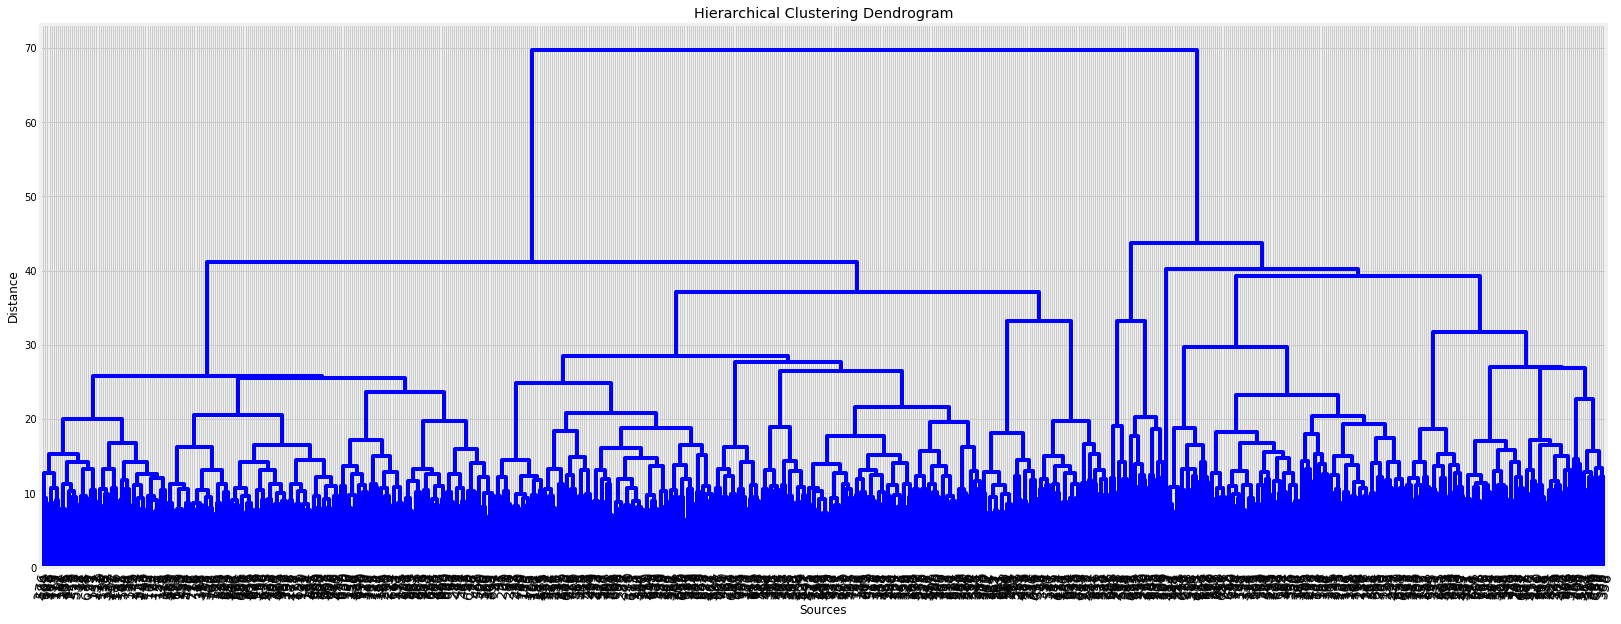

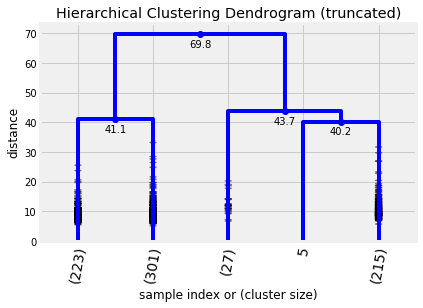

In [9]:
test_find_clusters_esp(get_dataframe_analysis_esp(True), 5)

## Obtaining clusters from data

These functions obtain the clusters from a dataframe and return another dataframe with a new column called `cultural_cluster` which represents the cluster related to cultural aspects assigned to each participant 

Also, we include two examples to show how to use the functions. The Euclidean distance used as a cutoff point to get the clusters in the examples is '28' as shown in the graphs displayed in the test functions `test_find_clusters_en()` and `test_find_clusters_esp()`

In [10]:
def get_dataframe_with_clusters_en(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_en(clusters)
    clusters = drop_optional_columns_en(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_en()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [11]:
def get_dataframe_with_clusters_esp(dataframe, max_euc_distance):
    
    clusters = dataframe.copy(True)
    clusters = drop_text_columns_esp(clusters)
    clusters = drop_optional_columns_esp(clusters)

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    my_subset = all_cultural_items
    clusters = clusters[sorted(clusters, key=lambda x: x not in my_subset)]

    columns_vC = clusters.columns.values.tolist()

    for item in all_cultural_items:
        columns_vC.remove(item)

    z_vCluster = scale(clusters.iloc[:, len(my_subset):])
    z_vCluster = pd.DataFrame(z_vCluster, columns=columns_vC)

    # display(z_vCluster.head())

    # Fitting our model.
    cluster_tree = linkage(z_vCluster, 'ward')
    
    dataframe_with_clusters = clusters
    clusters_got = fcluster(cluster_tree, max_euc_distance, criterion='distance')
    dataframe_with_clusters['cultural_cluster'] = clusters_got
    
    return dataframe_with_clusters

In [12]:
dataframe_with_clusters_en = get_dataframe_with_clusters_en(get_dataframe_analysis_en(True), 40)

print("Number of clusters: "+ str(len(dataframe_with_clusters_en['cultural_cluster'].unique())))
dataframe_with_clusters_en['cultural_cluster'].value_counts().sort_index()

Number of clusters: 5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



1    223
2    301
3     27
4    215
5      1
Name: cultural_cluster, dtype: int64

In [13]:
dataframe_with_clusters_esp = get_dataframe_with_clusters_esp(get_dataframe_analysis_esp(True), 40)

print("Número de clusters: "+ str(len(dataframe_with_clusters_esp['cultural_cluster'].unique())))
dataframe_with_clusters_esp['cultural_cluster'].value_counts().sort_index()

Número de clusters: 5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



1    223
2    301
3     27
4    215
5      1
Name: cultural_cluster, dtype: int64

In [14]:
def visualize_cultural_clusters_esp(dataframe):
    # Visualizing the clusters
    # We don't use a discrete colorscale due to Plotly does not support that in this moment https://github.com/plotly/plotly.js/issues/1968

    # Using Cividis color scale for visualization. https://arxiv.org/abs/1712.01662

    cultural_items_dict = [
        {'id': 'Cult1', 'label': '¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?'},
        {'id': 'Cult2', 'label': '¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?'},
        {'id': 'Cult3', 'label': '¿Conoces autores/as que trabajen produciendo imágenes?'},
        {'id': 'Cult4', 'label': '¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?'},
        {'id': 'Cult5', 'label': 'Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?'},
        {'id': 'Cult6', 'label': 'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?'},
        {'id': 'Cult7',
            'label': 'Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?'},
        {'id': 'Cult8', 'label': 'En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?'},
        {'id': 'Cult9',
            'label': 'Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?'}
    ]

    #
    dimensions_list = []

    for item in cultural_items_dict:
        dimensions_list.append(
            dict(range=[dataframe[item['label']].min(), dataframe[item['label']].max()],
                 #constraintrange = [workCleanDummiesCluster[item['label']].min(), workCleanDummiesCluster[item['label']].max()/3],
                 label=item['id'],
                 values=dataframe[item['label']])
        )

    data = [
        go.Parcoords(
            showlegend=True,
            line=dict(color=dataframe['cultural_cluster'].unique().astype(int),
                      colorscale='Cividis',
                      showscale=True,
                      reversescale=False,
                      cmin=dataframe['cultural_cluster'].min(),
                      cmax=dataframe['cultural_cluster'].max()
                      ),
            dimensions=dimensions_list,
        )
    ]

    '''
    layout = Layout()
    '''

    fig = go.Figure(data=data)
    iplot(fig)

    for item in cultural_items_dict:
        print(item['id']+": "+item['label'])

    all_cultural_items, _, _, _ = get_cultural_items_esp()

    for selected_cluster in dataframe['cultural_cluster'].unique():
        for column in all_cultural_items:
            print("\n\nCluster "+str(selected_cluster) +
                  " || variable: "+str(column))
            print(f'Describiendo la pregunta {column}')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].describe())
            print(f'Conteo de cada valor en {column} expresada como valor / cantidad')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts().sort_index())
            print(f'Porcentaje de cada valor en {column} expresado como valor / porcentaje')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts(normalize=True).sort_index().round(4) * 100)
            # sns.distplot(workCleanDummiesCluster.loc[workCleanDummiesCluster['cluster'] == selected_cluster][column], kde=False, rug=True);
            data = [go.Bar(x=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].unique(),
                           y=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts().reindex(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].unique(), fill_value=0).sort_index())]
            iplot(data)
            plt.show()

In [15]:
def visualize_cultural_clusters_en(dataframe):
    # Visualizing the clusters
    # We don't use a discrete colorscale due to Plotly does not support that in this moment https://github.com/plotly/plotly.js/issues/1968

    # Using Cividis color scale for visualization. https://arxiv.org/abs/1712.01662

    cultural_items_dict = [
        {'id': 'Cult1', 'label': 'Do you think that images produced by men are different from those made by women?'},
        {'id': 'Cult2', 'label': 'Do you think that in the creation of images work more women, or men?'},
        {'id': 'Cult3', 'label': 'Do you know authors who work producing images?'},
        {'id': 'Cult4', 'label': 'Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?'},
        {'id': 'Cult5', 'label': 'When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?'},
        {'id': 'Cult6', 'label': 'By reusing an image, can you redefine the message that the sender has thought about?'},
        {'id': 'Cult7',
            'label': 'When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?'},
        {'id': 'Cult8', 'label': 'On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?'},
        {'id': 'Cult9',
            'label': 'When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?'}
    ]

    # {'id': 'Cult6', 'label': 'Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?'},

    dimensions_list = []

    for item in cultural_items_dict:
        dimensions_list.append(
            dict(range=[dataframe[item['label']].min(), dataframe[item['label']].max()],
                 #constraintrange = [workCleanDummiesCluster[item['label']].min(), workCleanDummiesCluster[item['label']].max()/3],
                 label=item['id'],
                 values=dataframe[item['label']])
        )

    data = [
        go.Parcoords(
            showlegend=True,
            line=dict(color=dataframe['cultural_cluster'].unique().astype(int),
                      colorscale='Cividis',
                      showscale=True,
                      reversescale=False,
                      cmin=dataframe['cultural_cluster'].min(),
                      cmax=dataframe['cultural_cluster'].max()
                      ),
            dimensions=dimensions_list,
        )
    ]

    '''
    layout = Layout()
    '''

    fig = go.Figure(data=data)
    iplot(fig)

    for item in cultural_items_dict:
        print(item['id']+": "+item['label'])

    # Visualizing with bar charts the cultural aspects of each cluster

    all_cultural_items, _, _, _ = get_cultural_items_en()

    for selected_cluster in dataframe['cultural_cluster'].unique():
        for column in all_cultural_items:
            print("\n\nCluster "+str(selected_cluster) +
                  " || feature: "+str(column))
            
            
            print(f'Describing the feature {column}')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].describe())
            print(f'Count of each value in {column} expresed as value / amount')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts().sort_index())
            print(f'Percentage of each value in {column} expresed as value / percentage')
            display(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts(normalize=True).sort_index().round(4) * 100)
            # sns.distplot(workCleanDummiesCluster.loc[workCleanDummiesCluster['cluster'] == selected_cluster][column], kde=False, rug=True);
            data = [go.Bar(x=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].unique(),
                           y=dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].value_counts().reindex(dataframe.loc[dataframe['cultural_cluster'] == selected_cluster][column].unique(), fill_value=0).sort_index())]
            iplot(data)
            plt.show()

In [16]:
visualize_cultural_clusters_esp(dataframe_with_clusters_esp)

Cult1: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Cult2: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Cult3: ¿Conoces autores/as que trabajen produciendo imágenes?
Cult4: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Cult5: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Cult6: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Cult7: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Cult8: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entie

count    301.000000
mean       0.328904
std        0.470597
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Conteo de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresada como valor / cantidad


0    202
1     99
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: int64

Porcentaje de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresado como valor / porcentaje


0    67.11
1    32.89
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64



Cluster 2 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Describiendo la pregunta ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    301.000000
mean       2.697674
std        0.874621
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Conteo de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresada como valor / cantidad


1     43
2     45
3    173
4     40
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: int64

Porcentaje de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresado como valor / porcentaje


1    14.29
2    14.95
3    57.48
4    13.29
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64



Cluster 2 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?
Describiendo la pregunta ¿Conoces autores/as que trabajen produciendo imágenes?


count    301.000000
mean       0.259136
std        0.438890
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Conteo de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresada como valor / cantidad


0    223
1     78
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: int64

Porcentaje de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresado como valor / porcentaje


0    74.09
1    25.91
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64



Cluster 2 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Describiendo la pregunta ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    301.000000
mean       2.644518
std        1.062957
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Conteo de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresada como valor / cantidad


1     56
2     69
3    107
4     64
5      5
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: int64

Porcentaje de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresado como valor / porcentaje


1    18.60
2    22.92
3    35.55
4    21.26
5     1.66
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64



Cluster 2 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Describiendo la pregunta Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    301.000000
mean       2.671096
std        1.206149
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Conteo de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresada como valor / cantidad


1    72
2    53
3    93
4    68
5    15
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: int64

Porcentaje de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresado como valor / porcentaje


1    23.92
2    17.61
3    30.90
4    22.59
5     4.98
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64



Cluster 2 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Describiendo la pregunta Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    301.000000
mean       1.262458
std        1.003769
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Conteo de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresada como valor / cantidad


0     55
1    179
3     67
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: int64

Porcentaje de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresado como valor / porcentaje


0    18.27
1    59.47
3    22.26
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64



Cluster 2 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Describiendo la pregunta Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    301.000000
mean       2.990033
std        0.943345
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Conteo de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresada como valor / cantidad


1     19
2     66
3    127
4     77
5     12
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresado como valor / porcentaje


1     6.31
2    21.93
3    42.19
4    25.58
5     3.99
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64



Cluster 2 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?
Describiendo la pregunta En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    301.000000
mean       2.262458
std        1.128813
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Conteo de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresada como valor / cantidad


1    97
2    87
3    64
4    47
5     6
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: int64

Porcentaje de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresado como valor / porcentaje


1    32.23
2    28.90
3    21.26
4    15.61
5     1.99
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64



Cluster 2 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?
Describiendo la pregunta Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    301.000000
mean       3.119601
std        1.057819
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Conteo de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresada como valor / cantidad


1     21
2     61
3    108
4     83
5     28
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresado como valor / porcentaje


1     6.98
2    20.27
3    35.88
4    27.57
5     9.30
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64



Cluster 1 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Describiendo la pregunta ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Conteo de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresada como valor / cantidad


0    152
1     71
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: int64

Porcentaje de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresado como valor / porcentaje


0    68.16
1    31.84
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64



Cluster 1 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Describiendo la pregunta ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    223.000000
mean       2.856502
std        0.820371
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Conteo de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresada como valor / cantidad


1     17
2     42
3    120
4     44
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: int64

Porcentaje de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresado como valor / porcentaje


1     7.62
2    18.83
3    53.81
4    19.73
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64



Cluster 1 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?
Describiendo la pregunta ¿Conoces autores/as que trabajen produciendo imágenes?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Conteo de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresada como valor / cantidad


0    152
1     71
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: int64

Porcentaje de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresado como valor / porcentaje


0    68.16
1    31.84
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64



Cluster 1 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Describiendo la pregunta ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    223.000000
mean       2.802691
std        1.068211
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Conteo de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresada como valor / cantidad


1    28
2    52
3    96
4    30
5    17
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: int64

Porcentaje de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresado como valor / porcentaje


1    12.56
2    23.32
3    43.05
4    13.45
5     7.62
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64



Cluster 1 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Describiendo la pregunta Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    223.000000
mean       2.295964
std        1.074827
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Conteo de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresada como valor / cantidad


1    67
2    55
3    75
4    20
5     6
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: int64

Porcentaje de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresado como valor / porcentaje


1    30.04
2    24.66
3    33.63
4     8.97
5     2.69
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64



Cluster 1 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Describiendo la pregunta Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    223.000000
mean       1.452915
std        1.033789
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Conteo de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresada como valor / cantidad


0     27
1    132
3     64
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: int64

Porcentaje de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresado como valor / porcentaje


0    12.11
1    59.19
3    28.70
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64



Cluster 1 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Describiendo la pregunta Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    223.000000
mean       3.170404
std        1.114048
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Conteo de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresada como valor / cantidad


1    18
2    39
3    82
4    55
5    29
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresado como valor / porcentaje


1     8.07
2    17.49
3    36.77
4    24.66
5    13.00
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64



Cluster 1 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?
Describiendo la pregunta En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    223.000000
mean       1.748879
std        0.915180
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Conteo de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresada como valor / cantidad


1    107
2     82
3     21
4      9
5      4
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: int64

Porcentaje de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresado como valor / porcentaje


1    47.98
2    36.77
3     9.42
4     4.04
5     1.79
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64



Cluster 1 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?
Describiendo la pregunta Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    223.000000
mean       3.488789
std        1.021662
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Conteo de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresada como valor / cantidad


1     7
2    30
3    70
4    79
5    37
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresado como valor / porcentaje


1     3.14
2    13.45
3    31.39
4    35.43
5    16.59
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64



Cluster 5 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Describiendo la pregunta ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Conteo de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresada como valor / cantidad


0    1
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: int64

Porcentaje de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresado como valor / porcentaje


0    100.0
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64



Cluster 5 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Describiendo la pregunta ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Conteo de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresada como valor / cantidad


1    1
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: int64

Porcentaje de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresado como valor / porcentaje


1    100.0
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64



Cluster 5 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?
Describiendo la pregunta ¿Conoces autores/as que trabajen produciendo imágenes?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Conteo de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresada como valor / cantidad


0    1
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: int64

Porcentaje de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresado como valor / porcentaje


0    100.0
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64



Cluster 5 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Describiendo la pregunta ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Conteo de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresada como valor / cantidad


1    1
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: int64

Porcentaje de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresado como valor / porcentaje


1    100.0
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64



Cluster 5 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Describiendo la pregunta Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Conteo de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresada como valor / cantidad


3    1
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: int64

Porcentaje de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresado como valor / porcentaje


3    100.0
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64



Cluster 5 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Describiendo la pregunta Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Conteo de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresada como valor / cantidad


0    1
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: int64

Porcentaje de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresado como valor / porcentaje


0    100.0
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64



Cluster 5 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Describiendo la pregunta Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Conteo de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresada como valor / cantidad


2    1
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresado como valor / porcentaje


2    100.0
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64



Cluster 5 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?
Describiendo la pregunta En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Conteo de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresada como valor / cantidad


2    1
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: int64

Porcentaje de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresado como valor / porcentaje


2    100.0
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64



Cluster 5 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?
Describiendo la pregunta Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Conteo de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresada como valor / cantidad


3    1
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresado como valor / porcentaje


3    100.0
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64



Cluster 4 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Describiendo la pregunta ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    215.000000
mean       0.339535
std        0.474657
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Conteo de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresada como valor / cantidad


0    142
1     73
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: int64

Porcentaje de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresado como valor / porcentaje


0    66.05
1    33.95
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64



Cluster 4 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Describiendo la pregunta ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    215.000000
mean       2.483721
std        0.926487
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Conteo de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresada como valor / cantidad


1    40
2    56
3    94
4    25
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: int64

Porcentaje de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresado como valor / porcentaje


1    18.60
2    26.05
3    43.72
4    11.63
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64



Cluster 4 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?
Describiendo la pregunta ¿Conoces autores/as que trabajen produciendo imágenes?


count    215.000000
mean       0.316279
std        0.466108
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Conteo de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresada como valor / cantidad


0    147
1     68
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: int64

Porcentaje de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresado como valor / porcentaje


0    68.37
1    31.63
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64



Cluster 4 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Describiendo la pregunta ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    215.000000
mean       2.562791
std        0.978513
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Conteo de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresada como valor / cantidad


1    34
2    63
3    86
4    27
5     5
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: int64

Porcentaje de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresado como valor / porcentaje


1    15.81
2    29.30
3    40.00
4    12.56
5     2.33
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64



Cluster 4 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Describiendo la pregunta Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    215.000000
mean       2.413953
std        1.072507
min        1.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Conteo de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresada como valor / cantidad


1    57
2    47
3    81
4    25
5     5
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: int64

Porcentaje de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresado como valor / porcentaje


1    26.51
2    21.86
3    37.67
4    11.63
5     2.33
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64



Cluster 4 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Describiendo la pregunta Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    215.000000
mean       1.325581
std        1.117426
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Conteo de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresada como valor / cantidad


0     50
1    105
3     60
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: int64

Porcentaje de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresado como valor / porcentaje


0    23.26
1    48.84
3    27.91
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64



Cluster 4 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Describiendo la pregunta Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    215.000000
mean       2.781395
std        1.095286
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Conteo de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresada como valor / cantidad


1    32
2    47
3    86
4    36
5    14
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresado como valor / porcentaje


1    14.88
2    21.86
3    40.00
4    16.74
5     6.51
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64



Cluster 4 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?
Describiendo la pregunta En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    215.000000
mean       2.172093
std        1.073540
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Conteo de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresada como valor / cantidad


1    75
2    58
3    55
4    24
5     3
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: int64

Porcentaje de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresado como valor / porcentaje


1    34.88
2    26.98
3    25.58
4    11.16
5     1.40
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64



Cluster 4 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?
Describiendo la pregunta Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    215.000000
mean       2.925581
std        1.112397
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Conteo de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresada como valor / cantidad


1    27
2    44
3    78
4    50
5    16
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresado como valor / porcentaje


1    12.56
2    20.47
3    36.28
4    23.26
5     7.44
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64



Cluster 3 || variable: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?
Describiendo la pregunta ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?


count    27.000000
mean      0.481481
std       0.509175
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64

Conteo de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresada como valor / cantidad


0    14
1    13
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: int64

Porcentaje de cada valor en ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres? expresado como valor / porcentaje


0    51.85
1    48.15
Name: ¿Crees que las imágenes producidas por hombres son diferentes a las que hacen mujeres?, dtype: float64



Cluster 3 || variable: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?
Describiendo la pregunta ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?


count    27.000000
mean      2.592593
std       0.930643
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64

Conteo de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresada como valor / cantidad


1     4
2     7
3    12
4     4
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: int64

Porcentaje de cada valor en ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres? expresado como valor / porcentaje


1    14.81
2    25.93
3    44.44
4    14.81
Name: ¿Crees que en la creacción de imágenes trabajan más mujeres, u hombres?, dtype: float64



Cluster 3 || variable: ¿Conoces autores/as que trabajen produciendo imágenes?
Describiendo la pregunta ¿Conoces autores/as que trabajen produciendo imágenes?


count    27.000000
mean      0.222222
std       0.423659
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64

Conteo de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresada como valor / cantidad


0    21
1     6
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: int64

Porcentaje de cada valor en ¿Conoces autores/as que trabajen produciendo imágenes? expresado como valor / porcentaje


0    77.78
1    22.22
Name: ¿Conoces autores/as que trabajen produciendo imágenes?, dtype: float64



Cluster 3 || variable: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?
Describiendo la pregunta ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?


count    27.000000
mean      2.518519
std       1.051386
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64

Conteo de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresada como valor / cantidad


1    5
2    9
3    7
4    6
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: int64

Porcentaje de cada valor en ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones? expresado como valor / porcentaje


1    18.52
2    33.33
3    25.93
4    22.22
Name: ¿Te gusta seguir a personas que admiras en redes sociales? ¿Eres fan o follower de alguna? ¿En ocasiones escribes comentarios en sus publicaciones?, dtype: float64



Cluster 3 || variable: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?
Describiendo la pregunta Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?


count    27.000000
mean      2.259259
std       1.163304
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64

Conteo de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresada como valor / cantidad


1    10
2     4
3    10
4     2
5     1
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: int64

Porcentaje de cada valor en Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia? expresado como valor / porcentaje


1    37.04
2    14.81
3    37.04
4     7.41
5     3.70
Name: Cuando usas redes sociales, ¿consideras que ser aceptado como miembro de un grupo es más importante que tener autonomía e independencia?, dtype: float64



Cluster 3 || variable: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?
Describiendo la pregunta Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?


count    27.000000
mean      1.407407
std       1.118352
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64

Conteo de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresada como valor / cantidad


0     5
1    14
3     8
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: int64

Porcentaje de cada valor en Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado? expresado como valor / porcentaje


0    18.52
1    51.85
3    29.63
Name: Al reutilizar una imagen, ¿crees puedes redefinir el mensaje que el emisor ha pensado?, dtype: float64



Cluster 3 || variable: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?
Describiendo la pregunta Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?


count    27.000000
mean      2.666667
std       1.270978
min       1.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64

Conteo de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresada como valor / cantidad


1    8
2    2
3    9
4    7
5    1
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)? expresado como valor / porcentaje


1    29.63
2     7.41
3    33.33
4    25.93
5     3.70
Name: Cuando compartes imágenes en redes sociales, ¿las acompañas de texto siguiendo las indicaciones que te sugieren las aplicaciones (etiquetado, explicación de la imagen, texto inspirador, etc.)?, dtype: float64



Cluster 3 || variable: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?
Describiendo la pregunta En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?


count    27.000000
mean      1.962963
std       0.979854
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64

Conteo de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresada como valor / cantidad


1    11
2     8
3     6
4     2
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: int64

Porcentaje de cada valor en En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo? expresado como valor / porcentaje


1    40.74
2    29.63
3    22.22
4     7.41
Name: En alguna ocasión, aún estando preparado para ello, ¿has dejado de incorporar imágenes en tus mensajes en redes sociales, aplicaciones móviles, etc., porque no entiendes cómo hacerlo?, dtype: float64



Cluster 3 || variable: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?
Describiendo la pregunta Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?


count    27.000000
mean      2.666667
std       1.240347
min       1.000000
25%       1.000000
50%       3.000000
75%       3.500000
max       5.000000
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

Conteo de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresada como valor / cantidad


1     8
2     1
3    11
4     6
5     1
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: int64

Porcentaje de cada valor en Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)? expresado como valor / porcentaje


1    29.63
2     3.70
3    40.74
4    22.22
5     3.70
Name: Cuando haces fotos desde cualquiera de los medios a tu alcance, ¿te facilitan el proceso las opciones que te ofrecen las aplicaciones (filtros, recortes, edición mediante grafismo, etc.)?, dtype: float64

In [17]:
visualize_cultural_clusters_en(dataframe_with_clusters_en)

Cult1: Do you think that images produced by men are different from those made by women?
Cult2: Do you think that in the creation of images work more women, or men?
Cult3: Do you know authors who work producing images?
Cult4: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Cult5: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Cult6: By reusing an image, can you redefine the message that the sender has thought about?
Cult7: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Cult8: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to d

count    301.000000
mean       0.328904
std        0.470597
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Count of each value in Do you think that images produced by men are different from those made by women? expresed as value / amount


0    202
1     99
Name: Do you think that images produced by men are different from those made by women?, dtype: int64

Percentage of each value in Do you think that images produced by men are different from those made by women? expresed as value / percentage


0    67.11
1    32.89
Name: Do you think that images produced by men are different from those made by women?, dtype: float64



Cluster 2 || feature: Do you think that in the creation of images work more women, or men?
Describing the feature Do you think that in the creation of images work more women, or men?


count    301.000000
mean       2.697674
std        0.874621
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Count of each value in Do you think that in the creation of images work more women, or men? expresed as value / amount


1     43
2     45
3    173
4     40
Name: Do you think that in the creation of images work more women, or men?, dtype: int64

Percentage of each value in Do you think that in the creation of images work more women, or men? expresed as value / percentage


1    14.29
2    14.95
3    57.48
4    13.29
Name: Do you think that in the creation of images work more women, or men?, dtype: float64



Cluster 2 || feature: Do you know authors who work producing images?
Describing the feature Do you know authors who work producing images?


count    301.000000
mean       0.259136
std        0.438890
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Count of each value in Do you know authors who work producing images? expresed as value / amount


0    223
1     78
Name: Do you know authors who work producing images?, dtype: int64

Percentage of each value in Do you know authors who work producing images? expresed as value / percentage


0    74.09
1    25.91
Name: Do you know authors who work producing images?, dtype: float64



Cluster 2 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Describing the feature Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    301.000000
mean       2.644518
std        1.062957
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Count of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / amount


1     56
2     69
3    107
4     64
5      5
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: int64

Percentage of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / percentage


1    18.60
2    22.92
3    35.55
4    21.26
5     1.66
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64



Cluster 2 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Describing the feature When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    301.000000
mean       2.671096
std        1.206149
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Count of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / amount


1    72
2    53
3    93
4    68
5    15
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: int64

Percentage of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / percentage


1    23.92
2    17.61
3    30.90
4    22.59
5     4.98
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64



Cluster 2 || feature: By reusing an image, can you redefine the message that the sender has thought about?
Describing the feature By reusing an image, can you redefine the message that the sender has thought about?


count    301.000000
mean       1.262458
std        1.003769
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Count of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / amount


0     55
1    179
3     67
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: int64

Percentage of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / percentage


0    18.27
1    59.47
3    22.26
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64



Cluster 2 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Describing the feature When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    301.000000
mean       2.990033
std        0.943345
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Count of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / amount


1     19
2     66
3    127
4     77
5     12
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: int64

Percentage of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / percentage


1     6.31
2    21.93
3    42.19
4    25.58
5     3.99
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64



Cluster 2 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?
Describing the feature On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    301.000000
mean       2.262458
std        1.128813
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Count of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / amount


1    97
2    87
3    64
4    47
5     6
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: int64

Percentage of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / percentage


1    32.23
2    28.90
3    21.26
4    15.61
5     1.99
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64



Cluster 2 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?
Describing the feature When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    301.000000
mean       3.119601
std        1.057819
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Count of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / amount


1     21
2     61
3    108
4     83
5     28
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: int64

Percentage of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / percentage


1     6.98
2    20.27
3    35.88
4    27.57
5     9.30
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64



Cluster 1 || feature: Do you think that images produced by men are different from those made by women?
Describing the feature Do you think that images produced by men are different from those made by women?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Count of each value in Do you think that images produced by men are different from those made by women? expresed as value / amount


0    152
1     71
Name: Do you think that images produced by men are different from those made by women?, dtype: int64

Percentage of each value in Do you think that images produced by men are different from those made by women? expresed as value / percentage


0    68.16
1    31.84
Name: Do you think that images produced by men are different from those made by women?, dtype: float64



Cluster 1 || feature: Do you think that in the creation of images work more women, or men?
Describing the feature Do you think that in the creation of images work more women, or men?


count    223.000000
mean       2.856502
std        0.820371
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Count of each value in Do you think that in the creation of images work more women, or men? expresed as value / amount


1     17
2     42
3    120
4     44
Name: Do you think that in the creation of images work more women, or men?, dtype: int64

Percentage of each value in Do you think that in the creation of images work more women, or men? expresed as value / percentage


1     7.62
2    18.83
3    53.81
4    19.73
Name: Do you think that in the creation of images work more women, or men?, dtype: float64



Cluster 1 || feature: Do you know authors who work producing images?
Describing the feature Do you know authors who work producing images?


count    223.000000
mean       0.318386
std        0.466898
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Count of each value in Do you know authors who work producing images? expresed as value / amount


0    152
1     71
Name: Do you know authors who work producing images?, dtype: int64

Percentage of each value in Do you know authors who work producing images? expresed as value / percentage


0    68.16
1    31.84
Name: Do you know authors who work producing images?, dtype: float64



Cluster 1 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Describing the feature Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    223.000000
mean       2.802691
std        1.068211
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Count of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / amount


1    28
2    52
3    96
4    30
5    17
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: int64

Percentage of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / percentage


1    12.56
2    23.32
3    43.05
4    13.45
5     7.62
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64



Cluster 1 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Describing the feature When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    223.000000
mean       2.295964
std        1.074827
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Count of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / amount


1    67
2    55
3    75
4    20
5     6
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: int64

Percentage of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / percentage


1    30.04
2    24.66
3    33.63
4     8.97
5     2.69
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64



Cluster 1 || feature: By reusing an image, can you redefine the message that the sender has thought about?
Describing the feature By reusing an image, can you redefine the message that the sender has thought about?


count    223.000000
mean       1.452915
std        1.033789
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Count of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / amount


0     27
1    132
3     64
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: int64

Percentage of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / percentage


0    12.11
1    59.19
3    28.70
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64



Cluster 1 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Describing the feature When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    223.000000
mean       3.170404
std        1.114048
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Count of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / amount


1    18
2    39
3    82
4    55
5    29
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: int64

Percentage of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / percentage


1     8.07
2    17.49
3    36.77
4    24.66
5    13.00
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64



Cluster 1 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?
Describing the feature On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    223.000000
mean       1.748879
std        0.915180
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Count of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / amount


1    107
2     82
3     21
4      9
5      4
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: int64

Percentage of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / percentage


1    47.98
2    36.77
3     9.42
4     4.04
5     1.79
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64



Cluster 1 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?
Describing the feature When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    223.000000
mean       3.488789
std        1.021662
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Count of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / amount


1     7
2    30
3    70
4    79
5    37
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: int64

Percentage of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / percentage


1     3.14
2    13.45
3    31.39
4    35.43
5    16.59
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64



Cluster 5 || feature: Do you think that images produced by men are different from those made by women?
Describing the feature Do you think that images produced by men are different from those made by women?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Count of each value in Do you think that images produced by men are different from those made by women? expresed as value / amount


0    1
Name: Do you think that images produced by men are different from those made by women?, dtype: int64

Percentage of each value in Do you think that images produced by men are different from those made by women? expresed as value / percentage


0    100.0
Name: Do you think that images produced by men are different from those made by women?, dtype: float64



Cluster 5 || feature: Do you think that in the creation of images work more women, or men?
Describing the feature Do you think that in the creation of images work more women, or men?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Count of each value in Do you think that in the creation of images work more women, or men? expresed as value / amount


1    1
Name: Do you think that in the creation of images work more women, or men?, dtype: int64

Percentage of each value in Do you think that in the creation of images work more women, or men? expresed as value / percentage


1    100.0
Name: Do you think that in the creation of images work more women, or men?, dtype: float64



Cluster 5 || feature: Do you know authors who work producing images?
Describing the feature Do you know authors who work producing images?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Do you know authors who work producing images?, dtype: float64

Count of each value in Do you know authors who work producing images? expresed as value / amount


0    1
Name: Do you know authors who work producing images?, dtype: int64

Percentage of each value in Do you know authors who work producing images? expresed as value / percentage


0    100.0
Name: Do you know authors who work producing images?, dtype: float64



Cluster 5 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Describing the feature Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Count of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / amount


1    1
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: int64

Percentage of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / percentage


1    100.0
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64



Cluster 5 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Describing the feature When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Count of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / amount


3    1
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: int64

Percentage of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / percentage


3    100.0
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64



Cluster 5 || feature: By reusing an image, can you redefine the message that the sender has thought about?
Describing the feature By reusing an image, can you redefine the message that the sender has thought about?


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Count of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / amount


0    1
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: int64

Percentage of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / percentage


0    100.0
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64



Cluster 5 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Describing the feature When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Count of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / amount


2    1
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: int64

Percentage of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / percentage


2    100.0
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64



Cluster 5 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?
Describing the feature On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Count of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / amount


2    1
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: int64

Percentage of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / percentage


2    100.0
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64



Cluster 5 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?
Describing the feature When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Count of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / amount


3    1
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: int64

Percentage of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / percentage


3    100.0
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64



Cluster 4 || feature: Do you think that images produced by men are different from those made by women?
Describing the feature Do you think that images produced by men are different from those made by women?


count    215.000000
mean       0.339535
std        0.474657
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Count of each value in Do you think that images produced by men are different from those made by women? expresed as value / amount


0    142
1     73
Name: Do you think that images produced by men are different from those made by women?, dtype: int64

Percentage of each value in Do you think that images produced by men are different from those made by women? expresed as value / percentage


0    66.05
1    33.95
Name: Do you think that images produced by men are different from those made by women?, dtype: float64



Cluster 4 || feature: Do you think that in the creation of images work more women, or men?
Describing the feature Do you think that in the creation of images work more women, or men?


count    215.000000
mean       2.483721
std        0.926487
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Count of each value in Do you think that in the creation of images work more women, or men? expresed as value / amount


1    40
2    56
3    94
4    25
Name: Do you think that in the creation of images work more women, or men?, dtype: int64

Percentage of each value in Do you think that in the creation of images work more women, or men? expresed as value / percentage


1    18.60
2    26.05
3    43.72
4    11.63
Name: Do you think that in the creation of images work more women, or men?, dtype: float64



Cluster 4 || feature: Do you know authors who work producing images?
Describing the feature Do you know authors who work producing images?


count    215.000000
mean       0.316279
std        0.466108
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Do you know authors who work producing images?, dtype: float64

Count of each value in Do you know authors who work producing images? expresed as value / amount


0    147
1     68
Name: Do you know authors who work producing images?, dtype: int64

Percentage of each value in Do you know authors who work producing images? expresed as value / percentage


0    68.37
1    31.63
Name: Do you know authors who work producing images?, dtype: float64



Cluster 4 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Describing the feature Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    215.000000
mean       2.562791
std        0.978513
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Count of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / amount


1    34
2    63
3    86
4    27
5     5
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: int64

Percentage of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / percentage


1    15.81
2    29.30
3    40.00
4    12.56
5     2.33
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64



Cluster 4 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Describing the feature When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    215.000000
mean       2.413953
std        1.072507
min        1.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Count of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / amount


1    57
2    47
3    81
4    25
5     5
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: int64

Percentage of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / percentage


1    26.51
2    21.86
3    37.67
4    11.63
5     2.33
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64



Cluster 4 || feature: By reusing an image, can you redefine the message that the sender has thought about?
Describing the feature By reusing an image, can you redefine the message that the sender has thought about?


count    215.000000
mean       1.325581
std        1.117426
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Count of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / amount


0     50
1    105
3     60
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: int64

Percentage of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / percentage


0    23.26
1    48.84
3    27.91
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64



Cluster 4 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Describing the feature When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    215.000000
mean       2.781395
std        1.095286
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Count of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / amount


1    32
2    47
3    86
4    36
5    14
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: int64

Percentage of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / percentage


1    14.88
2    21.86
3    40.00
4    16.74
5     6.51
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64



Cluster 4 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?
Describing the feature On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    215.000000
mean       2.172093
std        1.073540
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Count of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / amount


1    75
2    58
3    55
4    24
5     3
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: int64

Percentage of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / percentage


1    34.88
2    26.98
3    25.58
4    11.16
5     1.40
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64



Cluster 4 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?
Describing the feature When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    215.000000
mean       2.925581
std        1.112397
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Count of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / amount


1    27
2    44
3    78
4    50
5    16
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: int64

Percentage of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / percentage


1    12.56
2    20.47
3    36.28
4    23.26
5     7.44
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64



Cluster 3 || feature: Do you think that images produced by men are different from those made by women?
Describing the feature Do you think that images produced by men are different from those made by women?


count    27.000000
mean      0.481481
std       0.509175
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: Do you think that images produced by men are different from those made by women?, dtype: float64

Count of each value in Do you think that images produced by men are different from those made by women? expresed as value / amount


0    14
1    13
Name: Do you think that images produced by men are different from those made by women?, dtype: int64

Percentage of each value in Do you think that images produced by men are different from those made by women? expresed as value / percentage


0    51.85
1    48.15
Name: Do you think that images produced by men are different from those made by women?, dtype: float64



Cluster 3 || feature: Do you think that in the creation of images work more women, or men?
Describing the feature Do you think that in the creation of images work more women, or men?


count    27.000000
mean      2.592593
std       0.930643
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: Do you think that in the creation of images work more women, or men?, dtype: float64

Count of each value in Do you think that in the creation of images work more women, or men? expresed as value / amount


1     4
2     7
3    12
4     4
Name: Do you think that in the creation of images work more women, or men?, dtype: int64

Percentage of each value in Do you think that in the creation of images work more women, or men? expresed as value / percentage


1    14.81
2    25.93
3    44.44
4    14.81
Name: Do you think that in the creation of images work more women, or men?, dtype: float64



Cluster 3 || feature: Do you know authors who work producing images?
Describing the feature Do you know authors who work producing images?


count    27.000000
mean      0.222222
std       0.423659
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Do you know authors who work producing images?, dtype: float64

Count of each value in Do you know authors who work producing images? expresed as value / amount


0    21
1     6
Name: Do you know authors who work producing images?, dtype: int64

Percentage of each value in Do you know authors who work producing images? expresed as value / percentage


0    77.78
1    22.22
Name: Do you know authors who work producing images?, dtype: float64



Cluster 3 || feature: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?
Describing the feature Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?


count    27.000000
mean      2.518519
std       1.051386
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64

Count of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / amount


1    5
2    9
3    7
4    6
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: int64

Percentage of each value in Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications? expresed as value / percentage


1    18.52
2    33.33
3    25.93
4    22.22
Name: Do you like to follow people you admire in social networks? Are you a fan or follower of any of them? Do you sometimes write comments in their publications?, dtype: float64



Cluster 3 || feature: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?
Describing the feature When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?


count    27.000000
mean      2.259259
std       1.163304
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64

Count of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / amount


1    10
2     4
3    10
4     2
5     1
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: int64

Percentage of each value in When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence? expresed as value / percentage


1    37.04
2    14.81
3    37.04
4     7.41
5     3.70
Name: When you use social networks, do you consider that being accepted as a member of a group is more important than having autonomy and independence?, dtype: float64



Cluster 3 || feature: By reusing an image, can you redefine the message that the sender has thought about?
Describing the feature By reusing an image, can you redefine the message that the sender has thought about?


count    27.000000
mean      1.407407
std       1.118352
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       3.000000
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64

Count of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / amount


0     5
1    14
3     8
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: int64

Percentage of each value in By reusing an image, can you redefine the message that the sender has thought about? expresed as value / percentage


0    18.52
1    51.85
3    29.63
Name: By reusing an image, can you redefine the message that the sender has thought about?, dtype: float64



Cluster 3 || feature: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?
Describing the feature When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?


count    27.000000
mean      2.666667
std       1.270978
min       1.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64

Count of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / amount


1    8
2    2
3    9
4    7
5    1
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: int64

Percentage of each value in When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)? expresed as value / percentage


1    29.63
2     7.41
3    33.33
4    25.93
5     3.70
Name: When you share images on social networks, do the text companions follow the indications suggested by the applications (labeling, explanation of the image, inspiring text, etc.)?, dtype: float64



Cluster 3 || feature: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?
Describing the feature On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?


count    27.000000
mean      1.962963
std       0.979854
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64

Count of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / amount


1    11
2     8
3     6
4     2
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: int64

Percentage of each value in On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it? expresed as value / percentage


1    40.74
2    29.63
3    22.22
4     7.41
Name: On the occasion, even being prepared for it, have you stopped attaching images in your messages in social networks, mobile applications, etc., because you do not understand how to do it?, dtype: float64



Cluster 3 || feature: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?
Describing the feature When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?


count    27.000000
mean      2.666667
std       1.240347
min       1.000000
25%       1.000000
50%       3.000000
75%       3.500000
max       5.000000
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64

Count of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / amount


1     8
2     1
3    11
4     6
5     1
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: int64

Percentage of each value in When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)? expresed as value / percentage


1    29.63
2     3.70
3    40.74
4    22.22
5     3.70
Name: When you take photos from any of the media at your fingertips, do the process facilitate the options offered by the applications (filter application, cuts, graphic editing, etc.)?, dtype: float64